In [12]:
# pytorch tutorial
import numpy as np
import pdb
import torch
import matplotlib.pyplot as plt
%matplotlib inline
!pwd /Users/hjsong/Playground/Tutorials/PyTorchZeroToAll/

/private/var/folders/yd/s_9703bs5l74zt2rq7g9xxqw0000gn/T/spyder-hjsong/notebooks


In [57]:
class MyLinear3D():
    def __init__(self):
        self.data = None # storage for forward matrix of minibatch inputs
        self.w = np.array([0.1,0.1]).reshape((2,1)) # random length initial 2 array
        self.b = np.array([[0.1]]) # random scalar for initial bias
        
    def forward(self, X):
        """X: 2D array of size (nxd)
        w: np.array of size (dx1) or of an equivalent length 
        b: scalar bias term
        Returns (nx1) output vector
        """
        self.data = np.dot(X,self.w) + self.b
        return self.data
    
def loss(model, Y):
    """Assumes model has already passed an input matrix of (nxd) dimension
    (deprecated) X: 2D array of size (nxd)
    Y: array of length n (eg. (nx1), (n,) (1xn)) 
    Returns a batch squared loss"""
    Y_hat = model.data
    return np.dot((Y_hat-Y).transpose(), Y_hat-Y)[0][0] / (2*len(Y))

def grad(model,X, Y):
    """Returns gradient of batch_loss wrt w and b as a (1x3) vector"""
    E = model.data - Y  # e[i] = Y_hat[i] - Y[i]
#     print(f"E: {E.shape} should be {len(Y)}x1")
    X1 = np.c_[np.ones((X.shape[0],1)), X] 
    return np.dot(E.transpose(),X1).reshape((model.w.shape[0]+1,-1))

def check_grad(X,Y):
    pass

Let's implement next batch loader using python's generator

[read](https://medium.freecodecamp.org/how-and-why-you-should-use-python-generators-f6fb56650888)

In [14]:
# Get next batch's indices
## todo: is there an implementation without saving self.permuted list?
class NextIndices:
    def __init__(self, n, size):
        self.n = n
        self.size = size
        self.end = 0
        self.permuted = np.random.permutation(n)
        
    def __iter__(self):
        return self
    
    def __next__(self):
        self.end += self.size
        if self.end > self.n:
            raise StopIteration
        else: 
            return self.permuted[self.end-self.size: self.end]

In [17]:
nexti = NextIndices(8,4)
print(nexti.permuted)

for x in nexti:
    print(x)     

SyntaxError: invalid character in identifier (<ipython-input-17-f5e5a88f1d8f>, line 5)

In [36]:
def getX(n):
    """ 
    Creates nx2 data matrix for Exercise 3-2
    """
    X = np.zeros((n,2))
    X[:,0] = np.linspace(-10, 10, num=n)
    X[:,1] = X[:,0]**2
    return X

def getY(X, true_w, true_b):
    """ 
    Creates nx1 matrix for target of X
    with true weights, w = [w1, w2] and b
    """
    w = np.r_[true_b, true_w]
    X = np.c_[np.ones((X.shape[0], 1)), X]
    return np.dot(X, w).reshape((X.shape[0],-1))    

Test MyLinear3D model

In [37]:
# Get train data
n = 100
true_w = np.array([1,1]); true_b = 5
X = getX(100)
Y = getY(X, true_w, true_b)
print(f"X shape: {X.shape}, Y shape: {Y.shape}")
print(f"True w,b: {true_w}, {true_b}")

X shape: (100, 2), Y shape: (100, 1)
True w,b: [1 1], 5


In [46]:
myLinear = MyLinear3D()
print(f"Initial weights\n w: {myLinear.w},\n b: {myLinear.b}")

Initial weights
 w: [[0.1]
 [0.1]],
 b: [[0.1]]


In [47]:
myLinear.forward(X)
print("Forwarded a batch of shape", myLinear.data.shape)

Forwarded a batch of shape (100, 1)


In [48]:
l = loss(myLinear, Y)
print(type(l))
print(f"Batch loss: {l}")

<class 'numpy.float64'>
Batch loss: 1018.6928565266993


In [50]:
g = grad(myLinear,X, Y)
print(g.shape)
print(g)
print(g[:-1])
print(myLinear.w.shape)
print(myLinear.w - g[:-1])


E: (100, 1) should be 100x1
(3, 1)
[[  -3550.60606061]
 [  -3060.60606061]
 [-203984.50683758]]
[[-3550.60606061]
 [-3060.60606061]]
(2, 1)
[[3550.70606061]
 [3060.70606061]]


Experiments

In [51]:
myLinear = MyLinear3D()
print(f"Initial weights\n w: {myLinear.w},\n b: {myLinear.b}")

Initial weights
 w: [[0.1]
 [0.1]],
 b: [[0.1]]


In [52]:
#Hyperparams
alpha = 1e-6 #learning rate
bsize = 1 #batch size
# nBatches = n//bsize
verbose = True

In [63]:

# Train loop
bls = []
for epoch in range(200):
    # Get a batch
    count = 0
    nextGen = NextIndices(n, bsize)
    for bIdx in nextGen:
        count += 1
        X_batch, Y_batch = X[bIdx], Y[bIdx] 
        myLinear.forward(X_batch)
        l = loss(myLinear, Y_batch)
        g = grad(myLinear, X_batch, Y_batch)
#         print(l,g.shape)
        # gradient checking
    
        # update
        myLinear.w = myLinear.w - alpha*g[:-1]
        myLinear.b = myLinear.b - alpha*g[-1]
#         pdb.set_trace()
        bls.append(l)

    if verbose and (epoch%20 == 0):
        print(f"Epoch {epoch}: {l}")
        print(f"\t number of cycles: {count}")

Epoch 0: 146.6150603492586
	 number of cycles: 100
Epoch 20: 40.43553142157166
	 number of cycles: 100
Epoch 40: 68.68866619537869
	 number of cycles: 100
Epoch 60: 70.2154094014711
	 number of cycles: 100
Epoch 80: 113.55142715272962
	 number of cycles: 100
Epoch 100: 12.713072547071173
	 number of cycles: 100
Epoch 120: 44.96416288365378
	 number of cycles: 100
Epoch 140: 2.1765298751948357
	 number of cycles: 100
Epoch 160: 83.10794801624647
	 number of cycles: 100
Epoch 180: 101.97547942920323
	 number of cycles: 100


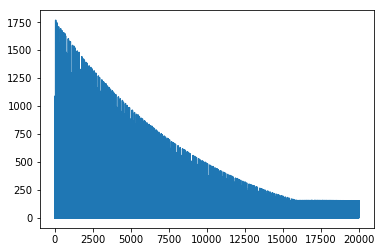

In [65]:
plt.plot(bls)

## Experiment with batch size

Batch size: 1
Initial weights
 w: [[0.1]
 [0.1]],
 b: [[0.1]]
Epoch 0: 56.545311848820674
	 number of cycles: 100
Epoch 50: 7.361886423202547
	 number of cycles: 100
Epoch 100: 12.224745560881141
	 number of cycles: 100
Epoch 150: 57.89325655642572
	 number of cycles: 100
Batch size: 10
Initial weights
 w: [[0.1]
 [0.1]],
 b: [[0.1]]
Epoch 0: 946.1180552091549
	 number of cycles: 10
Epoch 50: 466.7352048826377
	 number of cycles: 10
Epoch 100: 48.04632980891082
	 number of cycles: 10
Epoch 150: 58.600820546251406
	 number of cycles: 10
Batch size: 20
Initial weights
 w: [[0.1]
 [0.1]],
 b: [[0.1]]
Epoch 0: 1366.2871367638668
	 number of cycles: 5
Epoch 50: 638.7451025631483
	 number of cycles: 5
Epoch 100: 141.52499737745592
	 number of cycles: 5
Epoch 150: 137.18596305823127
	 number of cycles: 5
Batch size: 30
Initial weights
 w: [[0.1]
 [0.1]],
 b: [[0.1]]
Epoch 0: 905.8648084384811
	 number of cycles: 3
Epoch 50: 690.0085464751729
	 number of cycles: 3
Epoch 100: 156.9871800278191


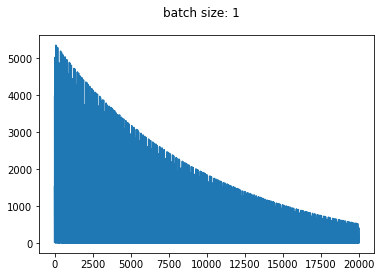

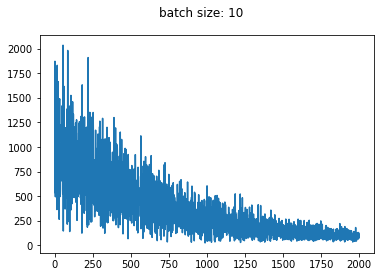

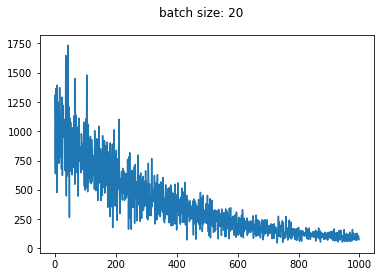

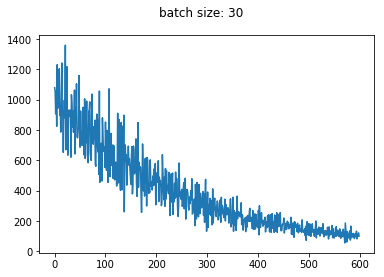

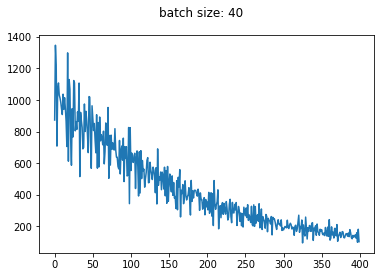

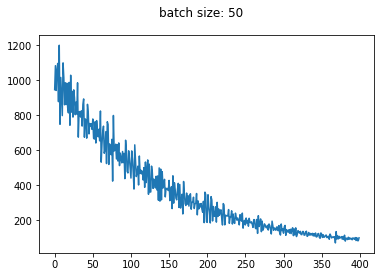

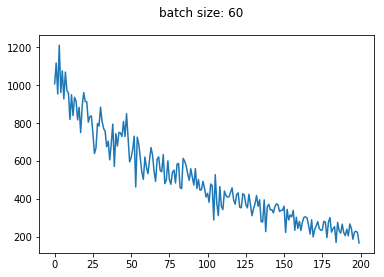

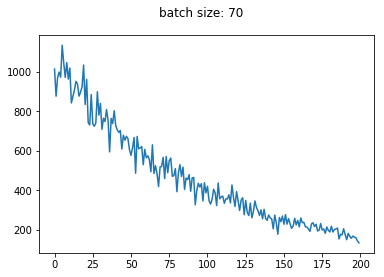

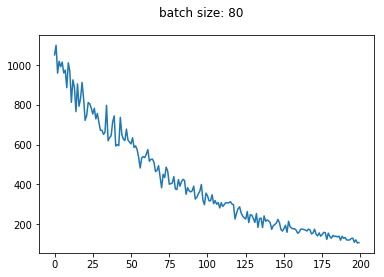

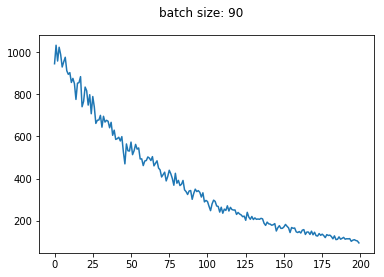

In [69]:
for bsize in np.arange(1,n,10)-1:
    if bsize == 0: bsize = 1
    print(f"Batch size: {bsize}")
    
    myLinear = MyLinear3D()
    print(f"Initial weights\n w: {myLinear.w},\n b: {myLinear.b}")
    
    # Train loop
    losses = []
    for epoch in range(200):
        # Get a batch
        count = 0
        nextGen = NextIndices(n, bsize)
        for bIdx in nextGen:
            count += 1
            X_batch, Y_batch = X[bIdx], Y[bIdx] 
            myLinear.forward(X_batch)
            l = loss(myLinear, Y_batch)
            g = grad(myLinear, X_batch, Y_batch)
    #         print(l,g.shape)
            # gradient checking

            # update
            myLinear.w = myLinear.w - alpha*g[:-1]
            myLinear.b = myLinear.b - alpha*g[-1]
    #         pdb.set_trace()
            losses.append(l)

        if verbose and (epoch%50 == 0):
            print(f"Epoch {epoch}: {l}")
            print(f"\t number of cycles: {count}")
        
    f,ax = plt.subplots()
    f.suptitle(f"batch size: {bsize}")
    ax.plot(losses)
